In [1]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas_market_calendars import get_calendar
from dateutil.relativedelta import relativedelta

In [2]:
engine = sqlalchemy.create_engine("sqlite:///C:/Users/lewis/OneDrive/tradingstrategies/databases/momentum_strategy_2_database.db")
calendar = get_calendar("NYSE")
polygon_api_key = "KkfCQ7fsZnx0yK4bhX9fD81QplTh0Pf3"

In [3]:
gross_returns = pd.read_sql("SELECT * FROM gross_returns", con = engine)
stock_prices = pd.read_sql("SELECT * FROM stock_returns", con = engine)

In [4]:
gross_returns = gross_returns.set_index('ticker')

In [5]:
end_date = pd.to_datetime(gross_returns.columns[-1]).date()
start_date = end_date - relativedelta(years=3) - relativedelta(months = 11)
dates = calendar.schedule(start_date = start_date, end_date = end_date).index.strftime("%Y-%m-%d").values

In [8]:
pd.to_datetime(dates[90]).date()


datetime.date(2021, 2, 2)

In [30]:
portfolio_returns = pd.DataFrame(columns=['Date', 'Long Momentum Returns', 'Short Momentum Returns', 'Gross Returns'])
times = []

In [31]:
for date in dates:
    start_time = datetime.now()
    if date == dates[0]:
        portfolio_returns = pd.concat([portfolio_returns, pd.DataFrame([{'Date' : date, 'Long Momentum Returns' : 1, 'Short Momentum Returns': 1, 'Gross Returns' : 1}])], ignore_index=True)
    else:
        yday = dates[np.where(dates == date)[0][0]-1]
        screening_df = pd.DataFrame()
        screening_df['ticker'] = gross_returns.index
        screening_df['1m momentum'] = screening_df['ticker'].map(gross_returns.loc[:, (pd.to_datetime(yday).date() - relativedelta(months = 1)).strftime("%Y-%m-%d"):yday].cumprod(axis=1).iloc[:, -1]-1)
        screening_df['2w momentum'] = screening_df['ticker'].map(gross_returns.loc[:, (pd.to_datetime(yday).date() - relativedelta(weeks = 2)).strftime("%Y-%m-%d"):yday].cumprod(axis=1).iloc[:, -1]-1)
        screening_df['1w momentum'] = screening_df['ticker'].map(gross_returns.loc[:, (pd.to_datetime(yday).date() - relativedelta(weeks = 1)).strftime("%Y-%m-%d"):yday].cumprod(axis=1).iloc[:, -1]-1)
        screening_df['1d momentum'] = screening_df['ticker'].map(gross_returns.loc[:, (pd.to_datetime(yday).date() - relativedelta(days = 1)).strftime("%Y-%m-%d"):yday].cumprod(axis=1).iloc[:, -1]-1)
        #adm = average daily momentum
        screening_df['1m adm'] = screening_df['1m momentum'] / 20
        screening_df['2w adm'] = screening_df['2w momentum'] / 10
        screening_df['1w adm'] = screening_df['1w momentum'] / 5
        #ddm = difference in daily momentum
        screening_df['2w1m ddm'] = screening_df['2w adm'] - screening_df['1m adm']
        screening_df['1w2w ddm'] = screening_df['1w adm'] - screening_df['2w adm']
        increasing_momentum_conditions = (screening_df['1w adm'] > 0) & (screening_df['1w2w ddm'] > screening_df['2w1m ddm']) & (screening_df['1w adm'] > screening_df['2w adm']) & (screening_df['2w adm'] > screening_df['1m adm'])
        decreasing_momentum_conditions = (screening_df['1w adm'] < 0) & (screening_df['1w2w ddm'] > screening_df['2w1m ddm']) & (screening_df['1w adm'] < screening_df['2w adm']) & (screening_df['2w adm'] < screening_df['1m adm'])
        long_momentum_portfolio = screening_df[increasing_momentum_conditions]['ticker'].tolist()
        short_momentum_portfolio = screening_df[decreasing_momentum_conditions]['ticker'].tolist()
        long_return = (gross_returns[gross_returns.index.isin(long_momentum_portfolio)][date]).mean()
        short_return = ((((gross_returns[gross_returns.index.isin(short_momentum_portfolio)][date])-1)*-1)+1).mean()
        gross_return = (long_return*(len(long_momentum_portfolio)/(len(long_momentum_portfolio)+len(short_momentum_portfolio))) + short_return*(len(short_momentum_portfolio)/(len(long_momentum_portfolio)+len(short_momentum_portfolio))))
        portfolio_returns = pd.concat([portfolio_returns, pd.DataFrame([{'Date' : date, 'Long Momentum Returns' : long_return, 'Short Momentum Returns': short_return, 'Gross Returns' : gross_return}])], ignore_index=True)
        
        end_time = datetime.now()
        seconds_to_complete = (end_time - start_time).total_seconds()
        times.append(seconds_to_complete)
        iteration = round((np.where(dates==date)[0][0]/len(dates))*100,2)
        iterations_remaining = len(dates) - np.where(dates==date)[0][0]
        average_time_to_complete = np.mean(times)
        estimated_completion_time = (datetime.now() + timedelta(seconds = int(average_time_to_complete*iterations_remaining)))
        time_remaining = estimated_completion_time - datetime.now()
        
        print(f"{iteration}% complete, {time_remaining} left, ETA: {estimated_completion_time}")

0.1% complete, 0:00:32 left, ETA: 2024-08-24 22:53:35.500174
0.2% complete, 0:00:48 left, ETA: 2024-08-24 22:53:51.565718
0.3% complete, 0:00:48 left, ETA: 2024-08-24 22:53:51.614585
0.41% complete, 0:00:44 left, ETA: 2024-08-24 22:53:47.651488
0.51% complete, 0:00:42 left, ETA: 2024-08-24 22:53:45.686393
0.61% complete, 0:00:40 left, ETA: 2024-08-24 22:53:43.716317
0.71% complete, 0:00:38 left, ETA: 2024-08-24 22:53:41.743884
0.81% complete, 0:00:36 left, ETA: 2024-08-24 22:53:39.767443
0.91% complete, 0:00:35 left, ETA: 2024-08-24 22:53:38.799414
1.01% complete, 0:00:35 left, ETA: 2024-08-24 22:53:38.836315
1.12% complete, 0:00:35 left, ETA: 2024-08-24 22:53:38.868749
1.22% complete, 0:00:34 left, ETA: 2024-08-24 22:53:37.901793
1.32% complete, 0:00:35 left, ETA: 2024-08-24 22:53:38.951138
1.42% complete, 0:00:37 left, ETA: 2024-08-24 22:53:41.014348
1.52% complete, 0:00:38 left, ETA: 2024-08-24 22:53:42.069479
1.62% complete, 0:00:39 left, ETA: 2024-08-24 22:53:43.133344
1.72% compl

In [32]:
portfolio_returns

,Date,Long Momentum Returns,Short Momentum Returns,Gross Returns
0,2020-09-23,1,1,1
1,2020-09-24,0.985919,1.002082,0.998041
2,2020-09-25,1.022523,0.983531,0.994288
3,2020-09-28,1.01813,0.979895,1.005189
4,2020-09-29,0.999318,1.003819,1.000492
...,...,...,...,...
981,2024-08-19,1.008017,0.983043,1.005961
982,2024-08-20,0.992837,1.011957,0.993866
983,2024-08-21,1.011363,0.996673,1.01022
984,2024-08-22,0.992604,1.00401,0.99393


In [33]:
portfolio_returns = portfolio_returns.set_index('Date')

In [34]:
benchmark_data = pd.json_normalize(requests.get(f"https://api.polygon.io/v2/aggs/ticker/SPY/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
benchmark_data.index = pd.to_datetime(benchmark_data.index, unit="ms", utc=True).tz_convert("America/New_York").strftime("%Y-%m-%d")
benchmark_data['Benchmark Return'] = benchmark_data["c"].pct_change().fillna(0) + 1

In [35]:
benchmark_data = benchmark_data.drop(columns = ['v', 'vw', 'o', 'c', 'h', 'l', 'n'])

In [36]:
portfolio_returns = portfolio_returns.join(benchmark_data, how='left')

In [37]:
portfolio_returns['Cumulative Long Returns'] = portfolio_returns['Long Momentum Returns'].cumprod()
portfolio_returns['Cumulative Short Returns'] = portfolio_returns['Short Momentum Returns'].cumprod()
portfolio_returns['Cumulative Gross Returns'] = portfolio_returns['Gross Returns'].cumprod()
portfolio_returns['Cumulative Benchmark Returns'] = portfolio_returns['Benchmark Return'].cumprod()

In [38]:
portfolio_returns.index = pd.to_datetime(portfolio_returns.index)

In [39]:
portfolio_returns

,Long Momentum Returns,Short Momentum Returns,Gross Returns,Benchmark Return,Cumulative Long Returns,Cumulative Short Returns,Cumulative Gross Returns,Cumulative Benchmark Returns
Date,,,,,,,,
2020-09-23,1,1,1,1.000000,1,1,1,1.000000
2020-09-24,0.985919,1.002082,0.998041,1.002666,0.985919,1.002082,0.998041,1.002666
2020-09-25,1.022523,0.983531,0.994288,1.016167,1.008125,0.985579,0.99234,1.018876
2020-09-28,1.01813,0.979895,1.005189,1.016609,1.026402,0.965764,0.997489,1.035798
2020-09-29,0.999318,1.003819,1.000492,0.994554,1.025702,0.969452,0.99798,1.030157
...,...,...,...,...,...,...,...,...
2024-08-19,1.008017,0.983043,1.005961,1.009561,1.733954,0.409064,1.295054,1.734472
2024-08-20,0.992837,1.011957,0.993866,0.998374,1.721534,0.413955,1.28711,1.731651
2024-08-21,1.011363,0.996673,1.01022,1.003437,1.741095,0.412578,1.300265,1.737602


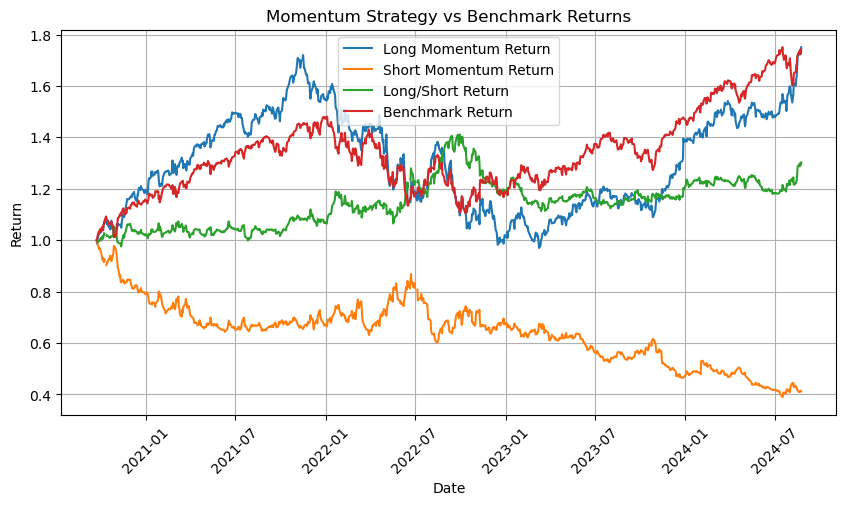

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(portfolio_returns.index, portfolio_returns['Cumulative Long Returns'], label='Long Momentum Return')
plt.plot(portfolio_returns.index, portfolio_returns['Cumulative Short Returns'], label='Short Momentum Return')
plt.plot(portfolio_returns.index, portfolio_returns['Cumulative Gross Returns'], label='Long/Short Return')
plt.plot(portfolio_returns.index, portfolio_returns['Cumulative Benchmark Returns'], label='Benchmark Return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Momentum Strategy vs Benchmark Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()